## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1 - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
%matplotlib inline

In [45]:
class CameraCalibration():
    pass
    def calibrate_camera():
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                #cv2.imshow('img',img)
                #cv2.waitKey(500)
                plt.figure()
                plt.imshow(img)
                plt.show()
            else:
                print('not found')
        #cv2.destroyAllWindows()
        return objpoints, imgpoints
    
    def undistort_image(objpoints, imgpoints, src_img):

        img_size = (src_img.shape[1], src_img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        result = cv2.undistort(src_img, mtx, dist, None, mtx)
        return result    

class PerspectiveTransformer():
    pass



not found


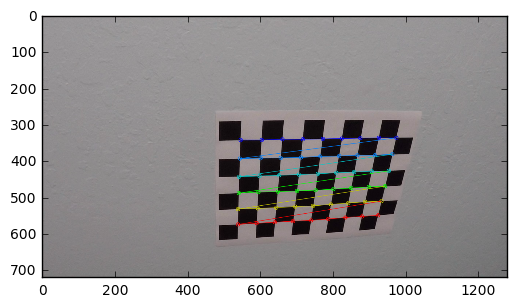

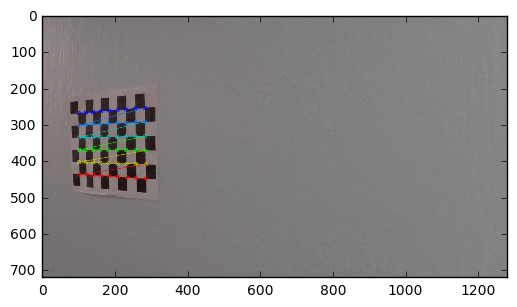

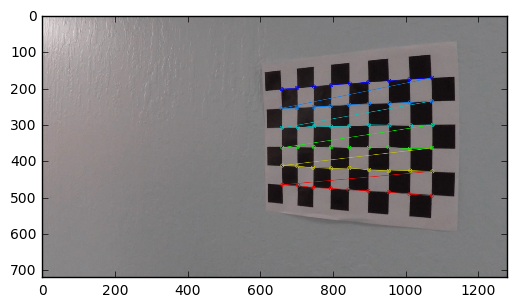

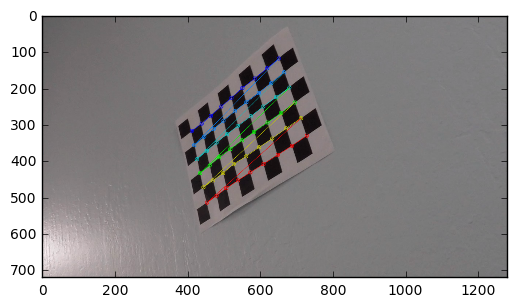

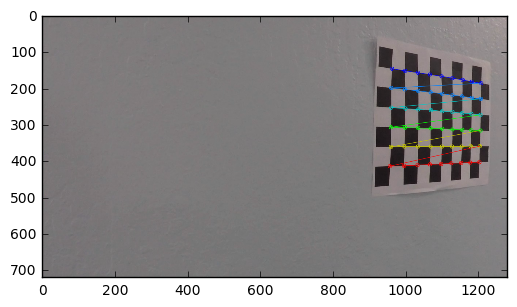

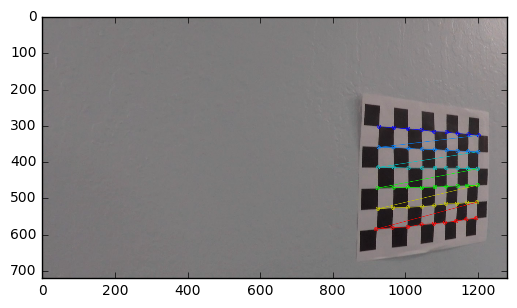

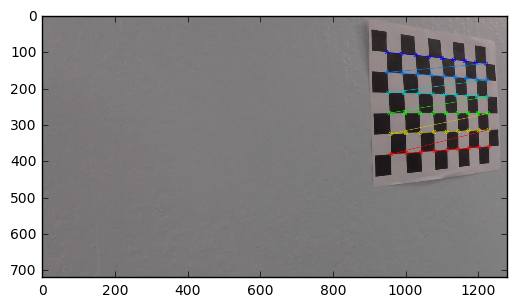

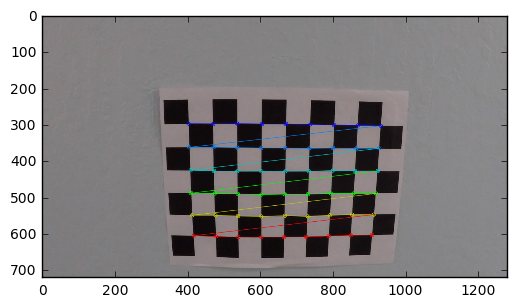

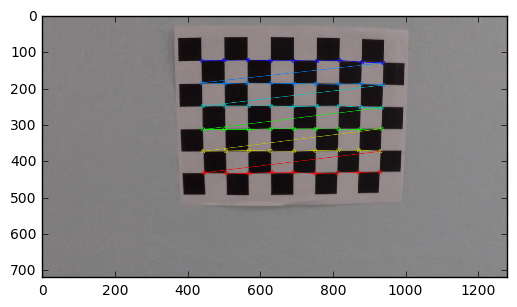

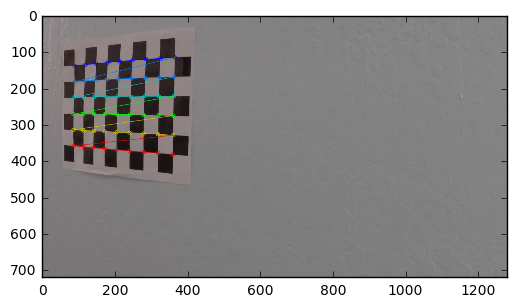

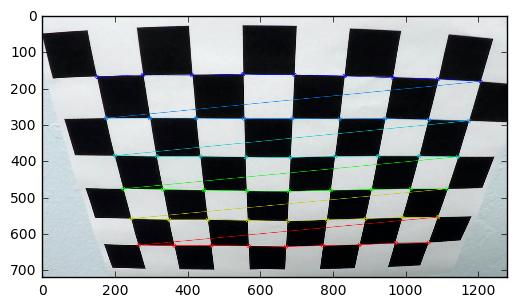

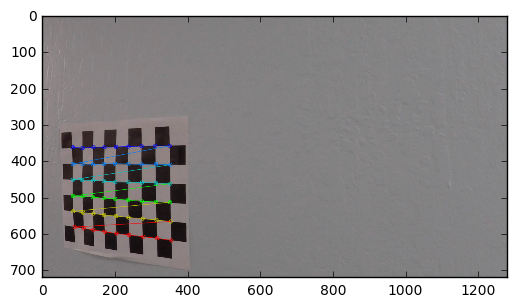

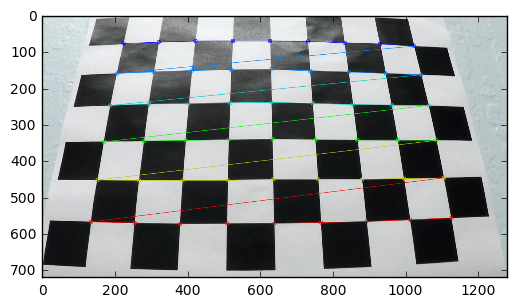

not found
not found


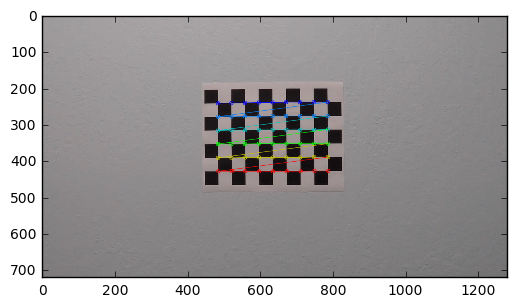

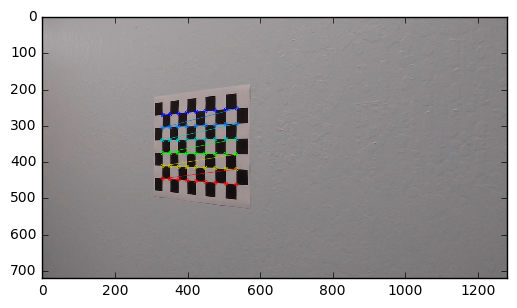

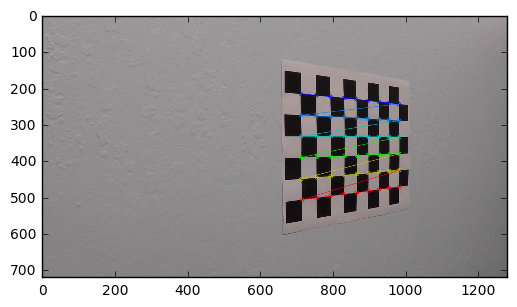

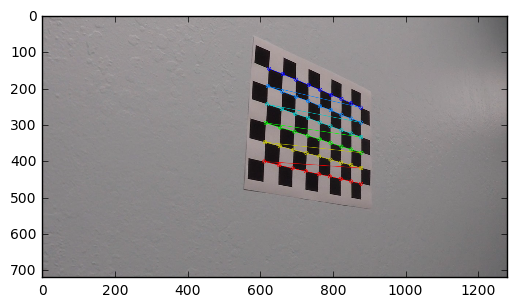

In [44]:
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
            plt.figure()
            plt.imshow(img)
            plt.show()
        else:
            print('not found')
    #cv2.destroyAllWindows()
    return objpoints, imgpoints

objpoints, imgpoints = calibrate_camera()

## Step2 - Apply a distortion correction to raw images.

In [4]:
def undistort_image(objpoints, imgpoints, src_img):

    img_size = (src_img.shape[1], src_img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    result = cv2.undistort(src_img, mtx, dist, None, mtx)
    return result



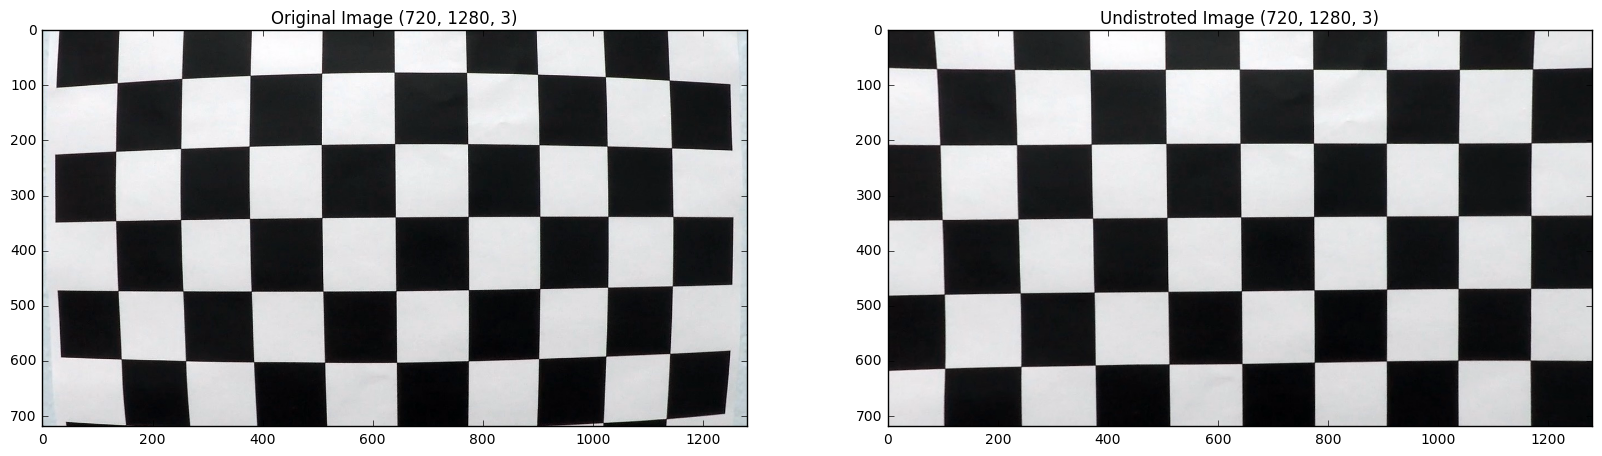

In [8]:
original_img = cv2.imread('camera_cal/calibration1.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Original Image {}'.format(original_img.shape))
ax1.imshow(original_img)

undistorted_img = undistort_image(objpoints, imgpoints, original_img)

ax2.set_title('Undistroted Image {}'.format(undistorted_img.shape))
ax2.imshow(undistorted_img)

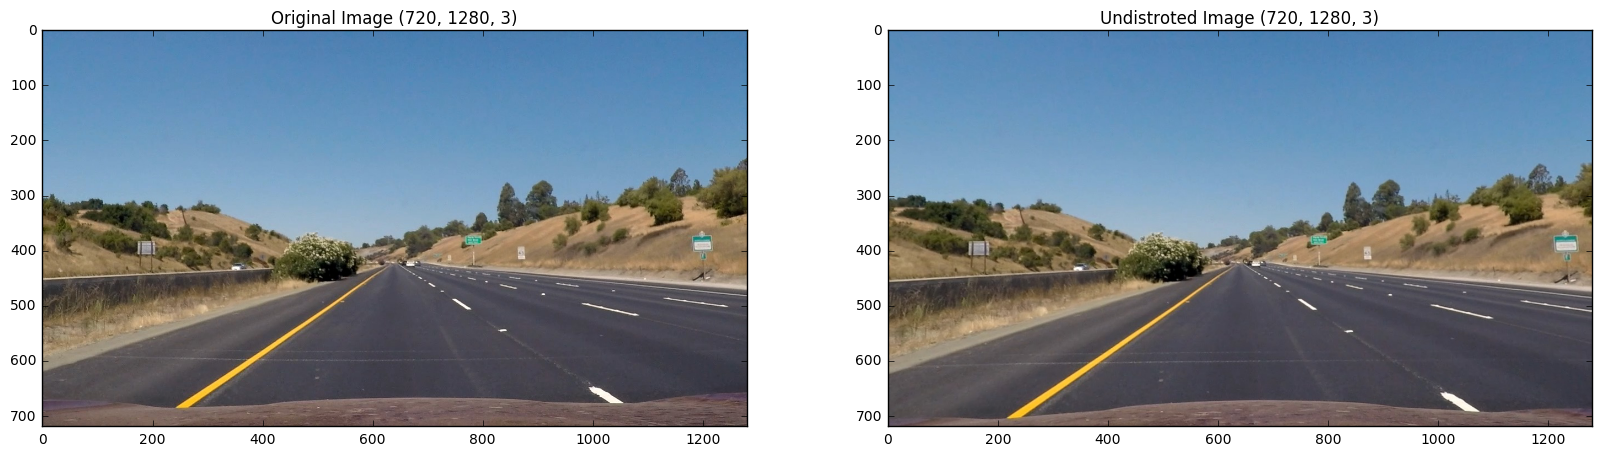

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

original_img = cv2.imread('test_images/straight_lines1.jpg')
original_img=cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
ax1.set_title('Original Image {}'.format(original_img.shape))
ax1.imshow(original_img)

undistorted_img = undistort_image(objpoints, imgpoints, original_img)
ax2.set_title('Undistroted Image {}'.format(undistorted_img.shape))
ax2.imshow(undistorted_img)

## Step3 - Use color transforms, gradients, etc., to create a thresholded binary image.

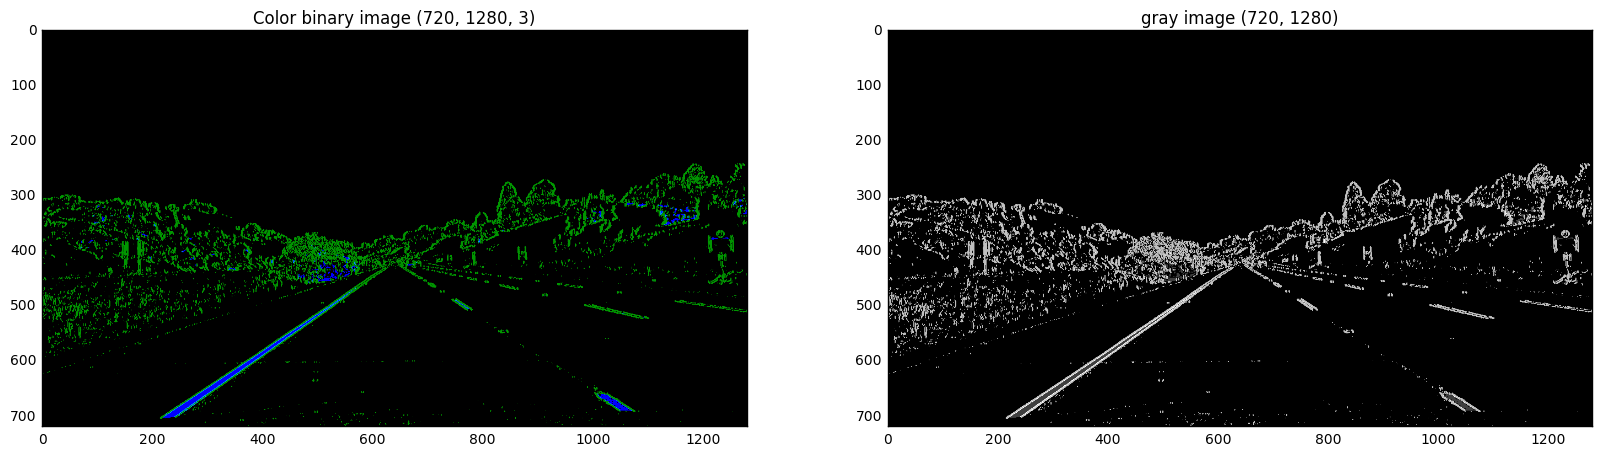

In [10]:
def pipeline(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold x gradient
    retval, sxbinary = cv2.threshold(abssx, 15, 150, cv2.THRESH_BINARY)
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), 175, 255, cv2.THRESH_BINARY)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

#hls_binary = hls_select(undistorted_img, thresh=(200, 255))   
#create_threshholded_binary_image(undistorted_img)
binary_img = pipeline(undistorted_img)
gray_img = cv2.cvtColor(binary_img, cv2.COLOR_RGB2GRAY)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Color binary image {}'.format(binary_img.shape))
ax1.imshow(binary_img)

ax2.set_title('gray image {}'.format(gray_img.shape))
ax2.imshow(gray_img, cmap='gray')

## Step4 - Apply a perspective transform to rectify binary image ("birds-eye view").

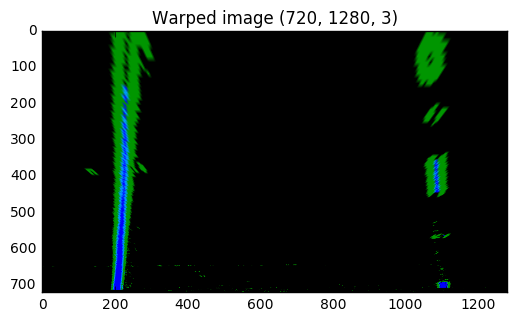

In [11]:
""" Helper methods"""
def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0, 0))

def calc_warp_points(img_height, img_width, x_offset, x_center_offset, y):
    
    xcenter = img_width / 2
    
    src = np.float32([(x_offset, img_height), (xcenter - x_center_offset, y), 
                     (xcenter + x_center_offset, y), (img_width - x_offset, img_height)])
    
    dst = np.float32(
        [(x_offset, img_height), (x_offset,0),
         (img_width - x_offset, 0), (img_width - x_offset, img_height)])
        
    return src, dst

def apply_perspective_tranform(undistorted, x_offset, x_center_offset, y):
    img = np.array(undistorted)
    src, dst = calc_warp_points(img.shape[0], img.shape[1], x_offset, x_center_offset, y)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #draw_lines(img, src)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    
    
@interact
def apply_perspective_tranform_test(undistorted=fixed(binary_img), x_offset:(0, 250)=127, \
                                   x_center_offset:(0, 100)=72, y:(0, 600)=459):

    binary_warped, _, _ = apply_perspective_tranform(undistorted, x_offset, x_center_offset, y)
    
    plt.figure()
    plt.title('Warped image {}'.format(binary_warped.shape))
    plt.imshow(binary_warped, cmap='gray')


In [12]:
color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)


## Step5 - Detect lane pixels and fit to find the lane boundary.

In [13]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

def test_window_centroid():
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results {}'.format(output.shape))
    plt.show()

In [14]:
## Step6 - Determine the curvature of the lane and vehicle position with respect to center.

In [21]:
def polyfitLanes(window_centroids):
    leftx = np.array([])
    rightx = np.array([])
    for level in range(0,len(window_centroids)):
        for i in range(window_height):
            leftx = np.append(leftx, window_centroids[level][0])
            rightx = np.append(rightx, window_centroids[level][1])
    # Fit a second order polynomial to pixel positions in each fake lane line

    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Plot up the fake data
#     mark_size = 3
#     plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#     plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
#     plt.xlim(0, 1280)
#     plt.ylim(0, 720)
#     plt.plot(left_fitx, ploty, color='green', linewidth=3)
#     plt.plot(right_fitx, ploty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images

    return leftx, rightx, left_fit, left_fitx, right_fit, right_fitx, ploty

leftx, rightx, left_fit, left_fitx, right_fit, right_fitx, ploty = polyfitLanes(window_centroids)

In [22]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [23]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
#print(result, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

## Step7 - Warp the detected lane boundaries back onto the original image.

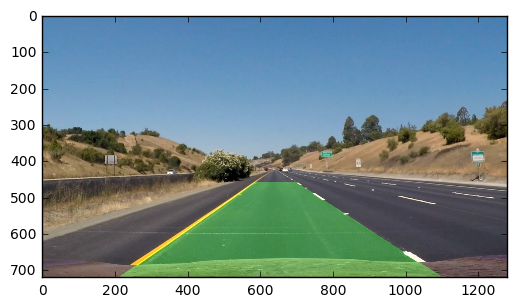

In [27]:
def overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty):
    image = original_img

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return result
    
overlay_img = overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty)
#overlay_img = overlayWarpedImageToOriginalImage(warped, original_img, left_fit_cr, right_fit_cr, ploty)
plt.imshow(overlay_img)

## Test

In [28]:
def load_test_video(file_name='project_video.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

In [29]:
images = load_test_video()

100%|█████████▉| 1260/1261 [00:06<00:00, 202.64it/s]


In [34]:
def process_frame(frame_img, debug=False):

    # Step1: Undistort image using the camera calibration
    undistorted_img = undistort_image(objpoints, imgpoints, frame_img)
    
    # Step2: Use color transforms, gradients, etc., to create a thresholded binary image 
    binary_img = pipeline(undistorted_img)
    #gray_img = cv2.cvtColor(binary_img, cv2.COLOR_RGB2GRAY)
    
    # Step3: Apply perspective transformation to create a warped image
    color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
    warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)

    # Step4: Get the sliding window polynomials for the left and right line
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    leftx, rightx, left_fit, left_fitx, right_fit, right_fitx, ploty = polyfitLanes(window_centroids)
    
    # Step5: Overlay the warped image to the original image
    result = overlayWarpedImageToOriginalImage(warped, frame_img, left_fitx, right_fitx, ploty)
    return result

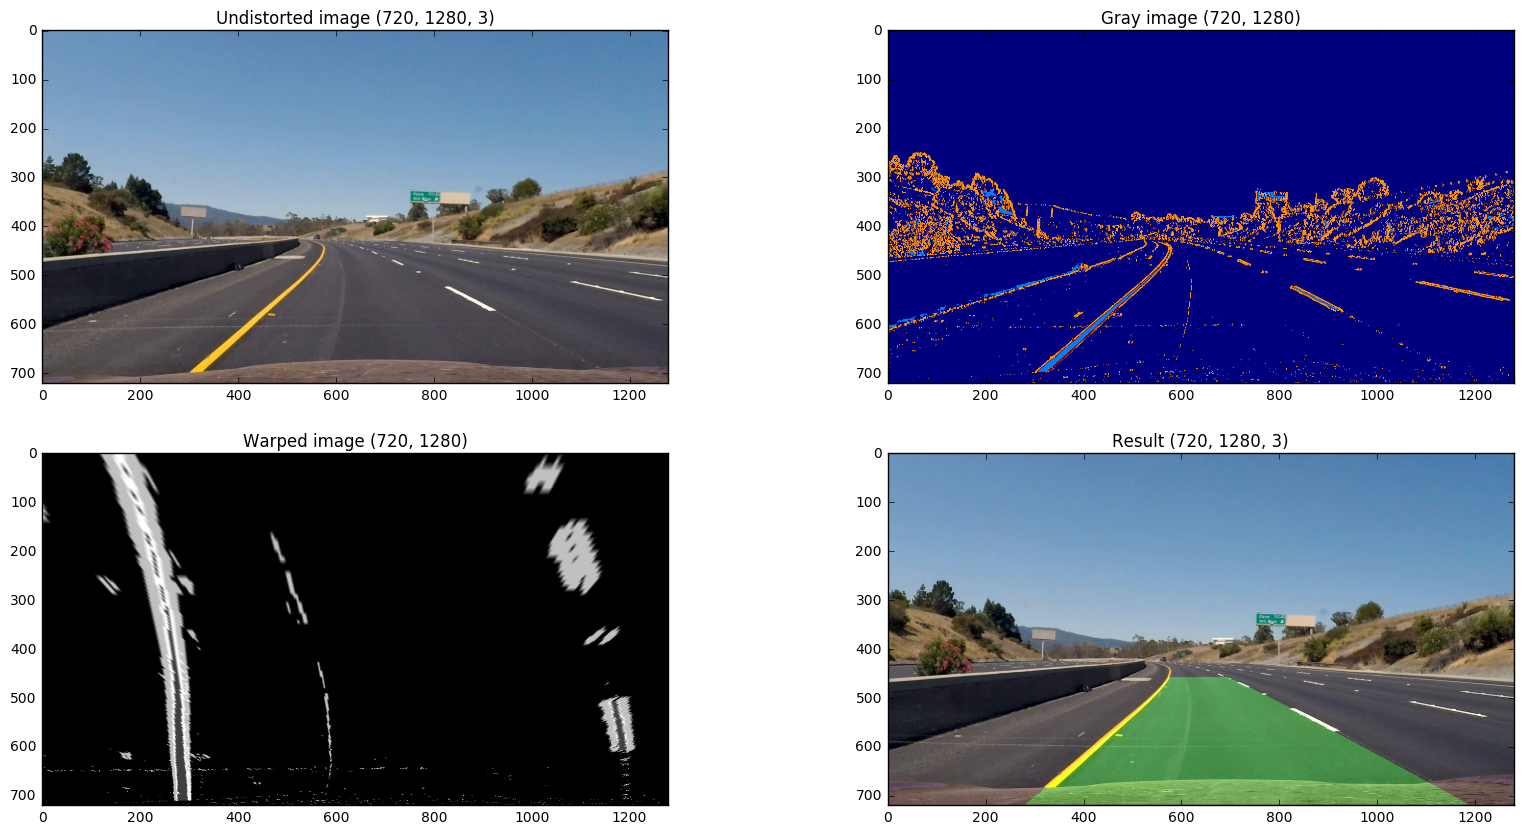

In [36]:
@interact
def testVideoImages(images=fixed(images), i:(0, len(images) - 1)=0):
    file, original_img = images[i]
    undistorted_img = undistort_image(objpoints, imgpoints, original_img)
    binary_img = pipeline(undistorted_img)
    gray_img = cv2.cvtColor(binary_img, cv2.COLOR_RGB2GRAY)
    color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
    warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    leftx, rightx, left_fit, left_fitx, right_fit, right_fitx, ploty = polyfitLanes(window_centroids)
    result = overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty)

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

    ax1.set_title('Undistorted image {}'.format(undistorted_img.shape))
    ax1.imshow(undistorted_img)

    ax2.set_title('Gray image {}'.format(gray_img.shape))
    ax2.imshow(gray_img)

    ax3.set_title('Warped image {}'.format(warped.shape))
    ax3.imshow(warped, cmap='gray')    
    
    ax4.set_title('Result {}'.format(result.shape))
    ax4.imshow(result)

## Step8 - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [41]:
def processVideo(intput_file_name='project_video.mp4', output_file_name='project_video_result.mp4'):
    clip2 = VideoFileClip(intput_file_name).subclip(0, 2)
    #clip2.subclip(frame_start=5, frame_end=15).speedx(2) # works
    yellow_clip = clip2.fl_image(process_frame)
    %time yellow_clip.write_videofile(output_file_name, audio=False)
    
processVideo()

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4



 98%|█████████▊| 50/51 [00:29<00:00,  1.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 1min 15s, sys: 3.14 s, total: 1min 18s
Wall time: 30.1 s
